# Building a handwritten digits classifier

In this project, we'll build models that can classify handwritten digits. The data we will be using is downloaded from the sklearn.datasets.

Scikit-learn contains a number of datasets pre-loaded with the library, within the namespace of sklearn.datasets. The [load_digits() function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) returns a copy of the [hand-written digits dataset from UCI](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

# Introduction

Before the year 2000, institutions like the United States Post Office used handwriting recognition software to read addresses, zip codes, and more. One of their approaches, which consists of pre-processing handwritten images then feeding to a neural network model is detailed in [this paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.852.5499&rep=rep1&type=pdf).

Within the field of machine learning and pattern recognition, image classification (especially for handwritten text) is towards the difficult end of the spectrum. There are a few reasons for this.

First, each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. This means that a 128 x 128 image has 16384 features.

Second, images are often downsampled to lower resolutions and transformed to grayscale (no color). This is a limitation of compute power unfortunately. The resolution of a 8 megapixel photo has 3264 by 2448 pixels, for a total of 7,990,272 features (or about 8 million). Images of this resolution are usually scaled down to between 128 and 512 pixels in either direction for significantly faster processing. This often results in a loss of detail that's available for training and pattern matching.

Third, the features in an image don't have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression. In grayscale, each pixel is just represented as a brightness value ranging from 0 to 256.

Here's an example of how an image is represented across the different abstractions we care about:

<img src='single_image.svg', width='600px'>

Deep learning is effective in image classification because of the models' ability to learn hierarchical representations. At a high level, an effective deep learning model learns intermediate representations at each layer in the model and uses them in the prediction process. Here's a diagram that visualizes what the weights represent at each layer of a convolutional neural network, a type of network that's often used in image classification and unfortunately out of scope for this course, which was trained to identify faces.

<img src='nn_learns_hierarchy.png', width='600px'>

In the first hidden layer the network learned to represent edges and specific features of faces. In the second hidden layer, the weights seemed to represent higher level facial features like eyes and noses. Finally, the weights in the last hidden layer resemble faces that could be matched against. Each successive layer uses weights from previous layers to try to learn more complex representations.

# Load and visualise the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_digits

digits_data = load_digits()
digits_data.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [2]:
data = pd.DataFrame(digits_data['data'])
labels = pd.Series(digits_data['target'])
print(data.shape)
data.head()

(1797, 64)


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


Because dataframes are a tabular representation of data, each image is represented as a row of pixel values. To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (28 x 28 pixels). To visualize the image, we need to reshape these pixel values back into the 28 by 28 and plot them on a coordinate grid.

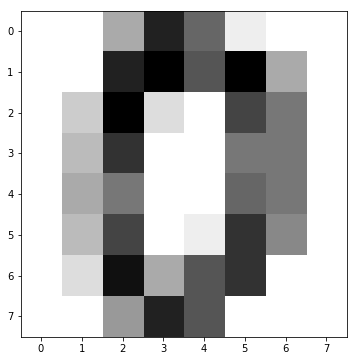

In [3]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8, 8)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.imshow(np_image, cmap='gray_r')

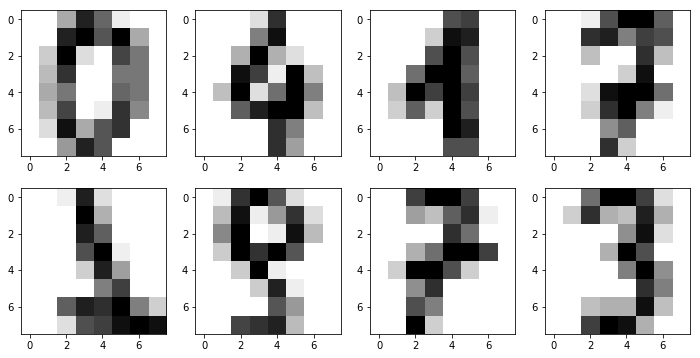

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(12,6))

image_num_0 = [0, 100, 200, 300]
image_num_1 = [1000, 1100, 1200, 1300]
for i in range(2):
    for j in range(4):
        if i == 0:
            image = data.iloc[image_num_0[j]]
            np_im = image.values.reshape(8, 8)
            ax[i, j].imshow(np_im, cmap='gray_r')
        else:
            image = data.iloc[image_num_1[j]]
            np_im = image.values.reshape(8, 8)
            ax[i, j].imshow(np_im, cmap='gray_r')

plt.show()

# Build the learning pipeline

## 1. K-Nearest Neigbors

While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm make no such assumption. This allows them to capture nonlinearity in the data. 

The k-nearest neighbors algorithm compares every unseen observation in the test set to all (or many, as some implementations constrain the search space) training observations to look for similar (or the "nearest") observations. Then, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def train_knn(nneighbors, train_features,train_labels):
    
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test_knn(model, test_features, test_labels):
    predictions = model.predict(test_features)
    return accuracy_score(test_labels, predictions)

def cross_validate_knn(df_features, df_labels, k, n_split):
    fold_accuracy = []
    kf = KFold(n_splits=n_split, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(df_features):
        train_features, test_features = df_features.loc[train_index], df_features.loc[test_index]
        train_labels, test_labels = df_labels.loc[train_index], df_labels.loc[test_index]
        model = train_knn(k, train_features, train_labels)
        accuracy = test_knn(model, test_features, test_labels)
        fold_accuracy.append(accuracy)
        
    return np.mean(fold_accuracy)

knn_1 = cross_validate_knn(data, labels, 1, 4)
knn_1 

0.9888728037614452

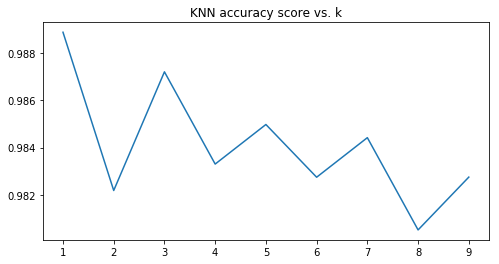

In [6]:
knn_k = []
for k in range(1, 10):
    knn_k.append(cross_validate_knn(data, labels, k, 4))
    
plt.figure(figsize=(8,4))
plt.plot(range(1, 10), knn_k)
plt.title('KNN accuracy score vs. k')
plt.show()

## 2. Neural Network with one hidden layer

There are a few downsides to using k-nearest neighbors:

high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
no model representation to debug and explore
Let's now try a neural network with a single hidden layer. Use the MLPClassifier package from scikit-learn.

In [7]:
from sklearn.neural_network import MLPClassifier

def train_nn(neuron_arch, train_features,train_labels):
    
    nn = MLPClassifier(hidden_layer_sizes=neuron_arch, max_iter=200)
    nn.fit(train_features, train_labels)
    return nn

def test_nn(model, test_features, test_labels):
    predictions = model.predict(test_features)
    return accuracy_score(test_labels, predictions)

def cross_validate_nn(df_features, df_labels, neuron_arch, n_split):
    fold_accuracy = []
    kf = KFold(n_splits=n_split, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(df_features):
        train_features, test_features = df_features.loc[train_index], df_features.loc[test_index]
        train_labels, test_labels = df_labels.loc[train_index], df_labels.loc[test_index]
        model = train_nn(neuron_arch, train_features, train_labels)
        accuracy = test_nn(model, test_features, test_labels)
        fold_accuracy.append(accuracy)
        
    return np.mean(fold_accuracy)


C:\Users\yiliu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


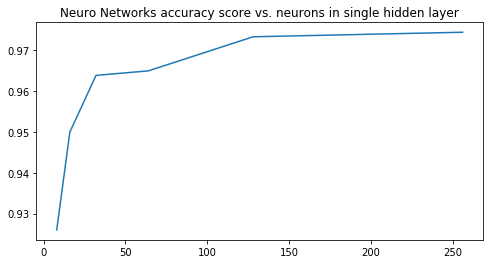

In [8]:
nn_one_neurons = [(8,),(16,),(32,),(64,),(128,),(256,)]
nn_k_one = []

for n in nn_one_neurons:
    nn_k_one.append(cross_validate_nn(data, labels, n, 4))
    
plt.figure(figsize=(8,4))
plt.plot([x[0] for x in nn_one_neurons], nn_k_one)
plt.title('Neuro Networks accuracy score vs. neurons in single hidden layer')
plt.show()

It looks like adding more neurons to the single hidden layer improved simple accuracy to approximately 97.5%. Simple accuracy computes the number of correct classifications the model made, but doesn't tell us anything about false or true positives or false or true negatives.

Given that k-nearest neighbors achieved approximately 98% accuracy, there doesn't seem to be any advantages to using a single hidden layer neural network for this problem

## 3. Neural Network with two hidden layers

C:\Users\yiliu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


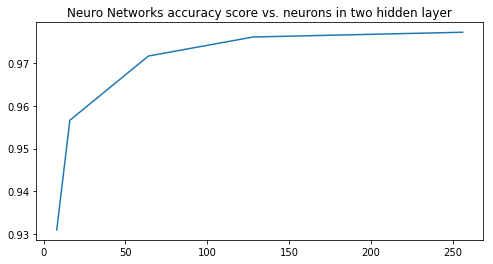

In [10]:
nn_two_neurons = [(8,8),(16,16),(32,32),(64,64),(128,128),(256,256)]
nn_k_two = []

for n in nn_two_neurons:
    nn_k_two.append(cross_validate_nn(data, labels, n, 4))
    
plt.figure(figsize=(8,4))
plt.plot([x[0] for x in nn_two_neurons], nn_k_two)
plt.title('Neuro Networks accuracy score vs. neurons in two hidden layer')
plt.show()

Using 2 hidden layers improved our simple accuracy close to 98%. While I'd traditionally be worried about overfitting, using 4-fold cross validation also gives me a bit more assurance that the model is generalizing to achieve the extra 0.5% in simple accuracy over the single hidden layer networks we tried earlier.

## 4. Neural Network with three hidden layers

C:\Users\yiliu\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


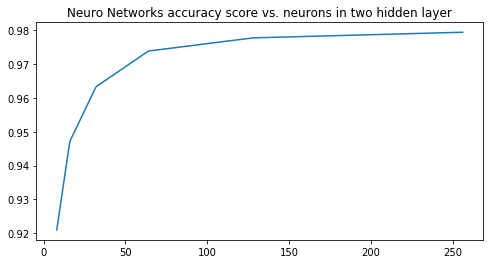

In [11]:
nn_three_neurons = [(8,8,8),(16,16,16),(32,32,32),(64,64,64),(128,128,128),(256,256,256)]
nn_k_three = []

for n in nn_three_neurons:
    nn_k_three.append(cross_validate_nn(data, labels, n, 6))
    
plt.figure(figsize=(8,4))
plt.plot([x[0] for x in nn_three_neurons], nn_k_three)
plt.title('Neuro Networks accuracy score vs. neurons in two hidden layer')
plt.show()

Using 3 hidden layers returned a simple accuracy of nearly 98%, even with 6-fold cross validation.

# Next steps

- Use the existing pipeline to try other machine learning models:
  - Decision Tree Models
  - Random Forest Models
- Experiment with different activation functions to see if the accuracies improve.
- Research some techniques for visualizing weights in neural network models and add a visualization step to the pipeline. 
  - [Visualization of MLP Weights on MNIST](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html)